In [ ]:
## TODO
## subclass nx.graph and store adj, D, etc as attribute variables
## Grabriel quality

In [1]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line

import criteria as C
import quality as Q
import gd2


## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math
from collections import defaultdict

## numeric
import numpy as np

import scipy.io as io

import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [2]:
# delete old
# !rm -r figures
# !mkdir figures

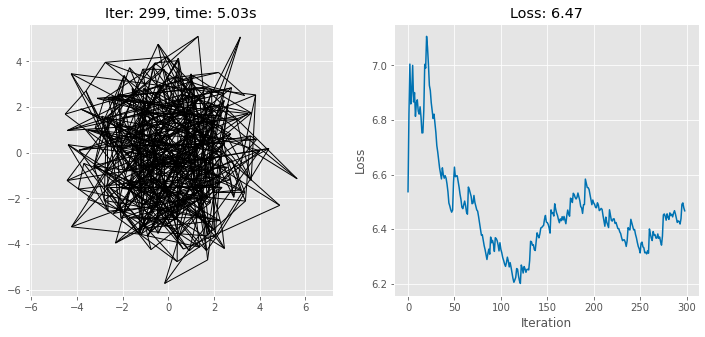

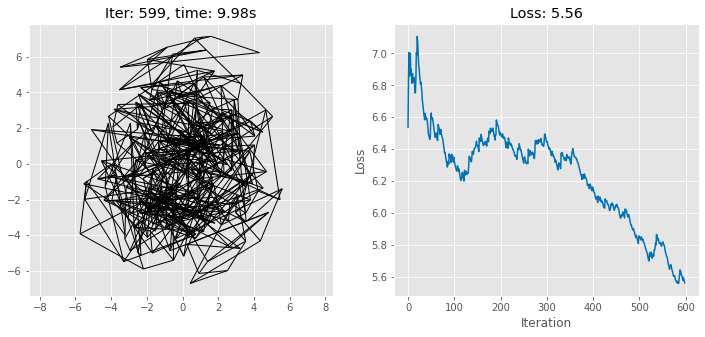

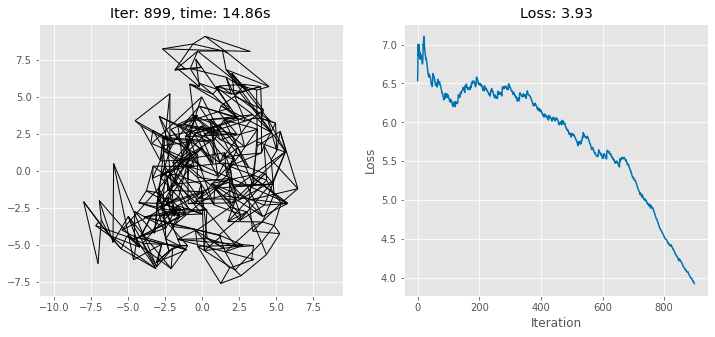

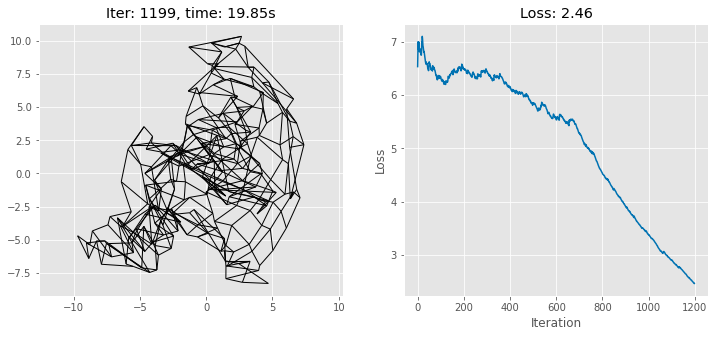

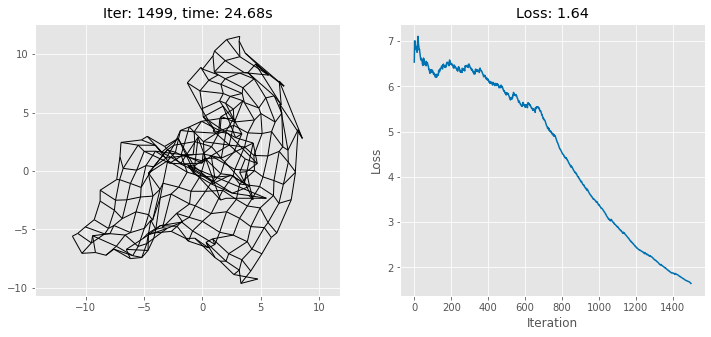

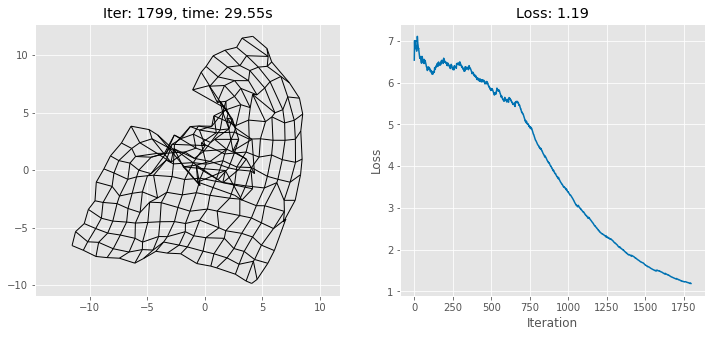

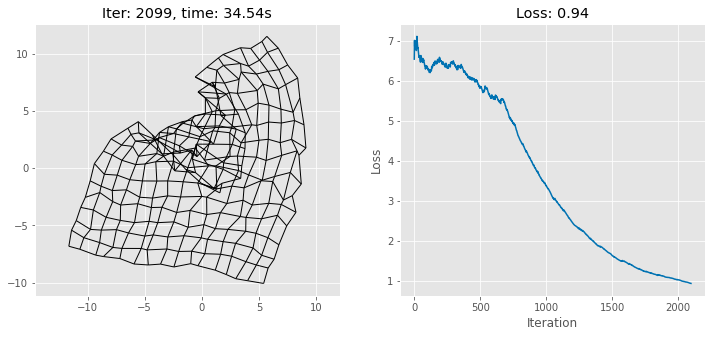

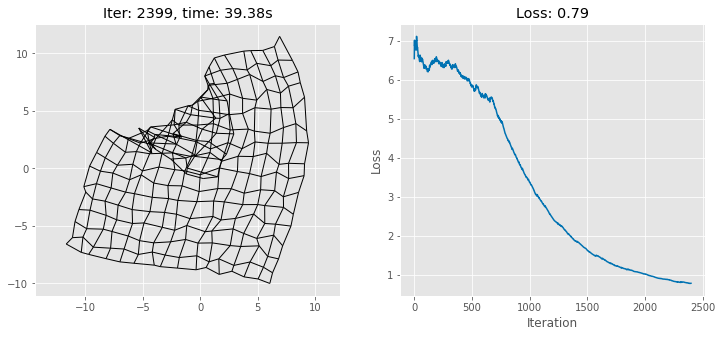

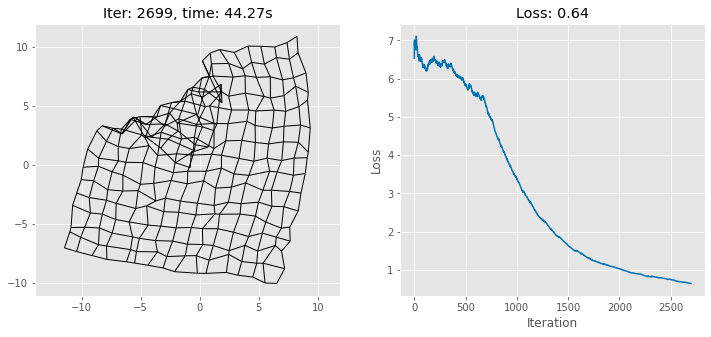

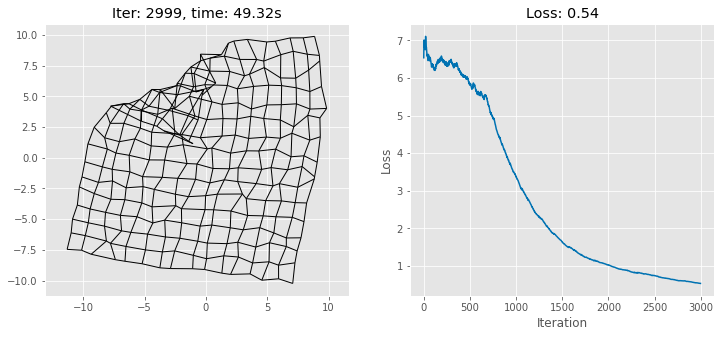

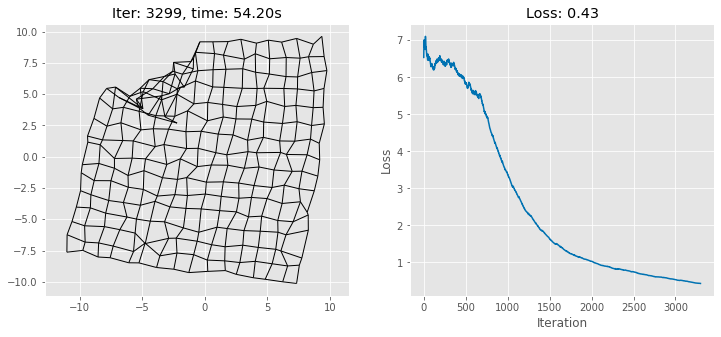

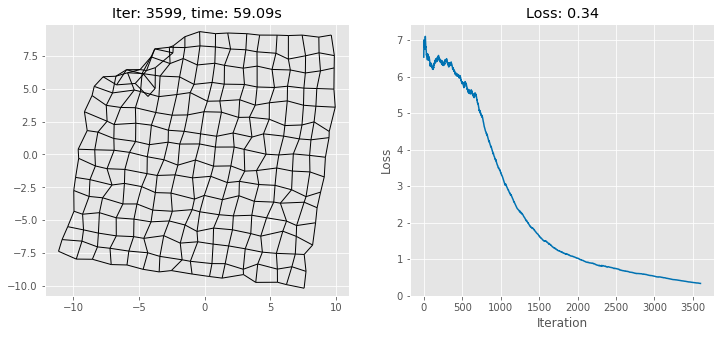

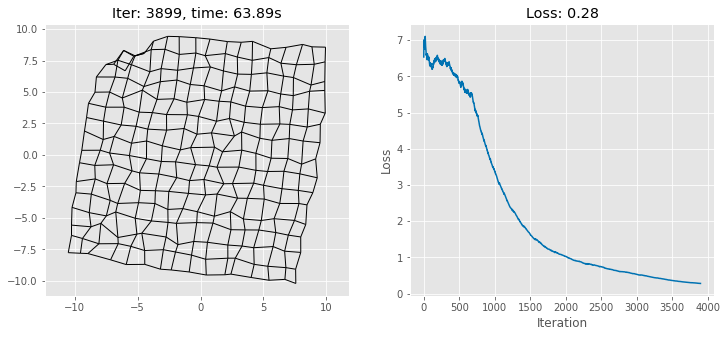

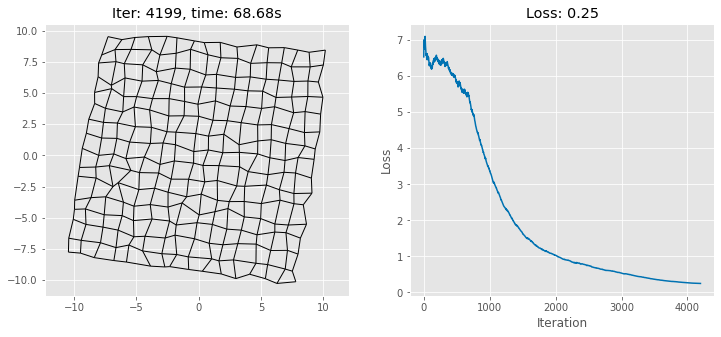

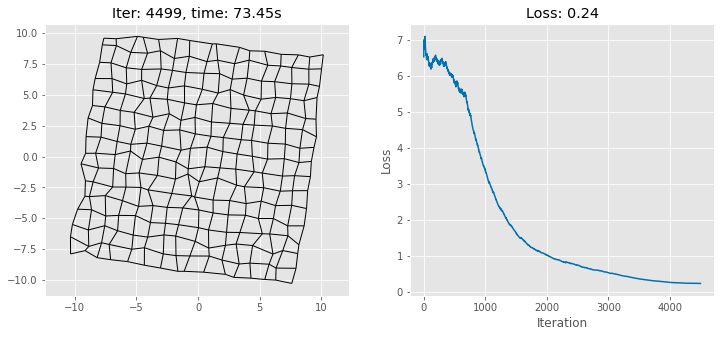

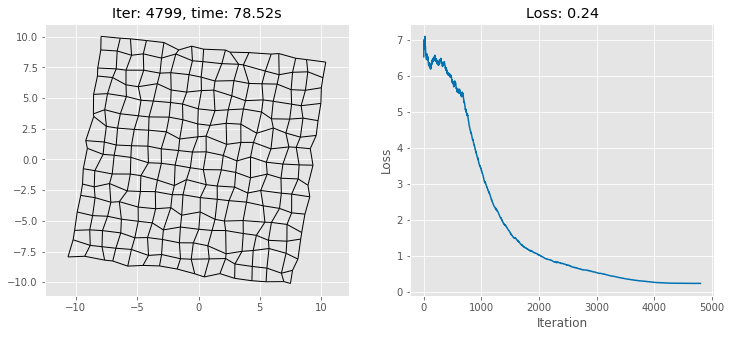

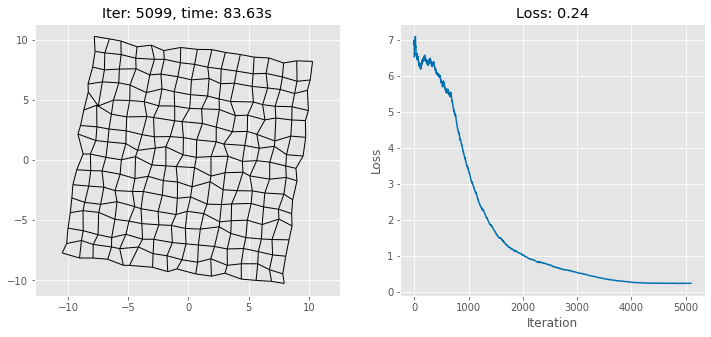

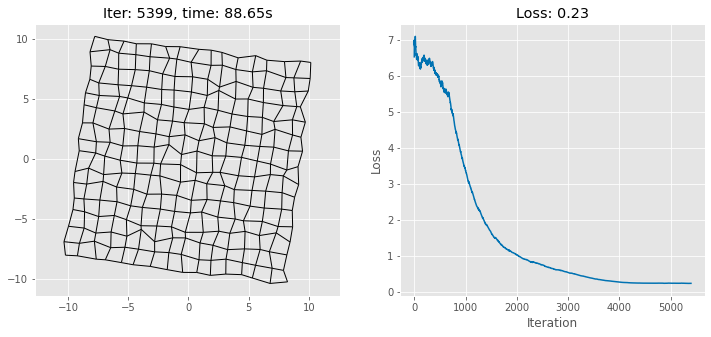

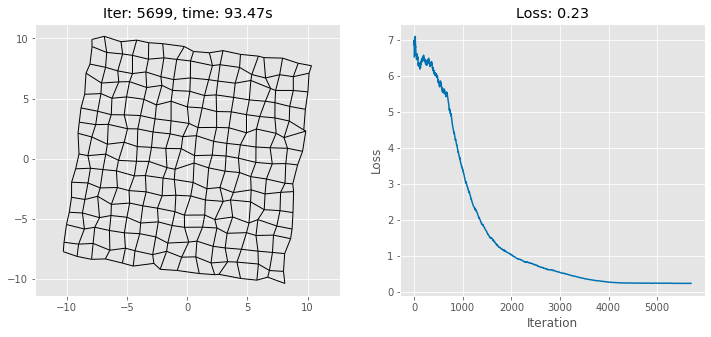

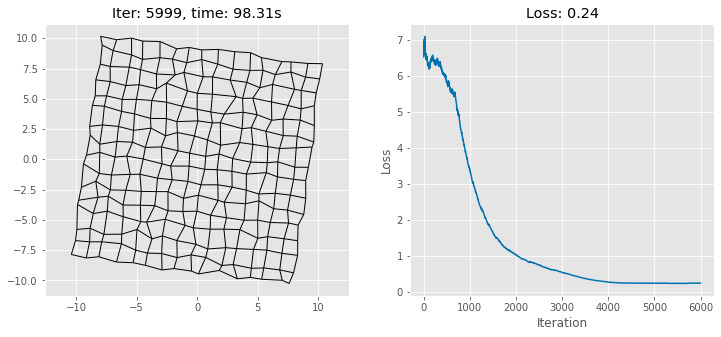

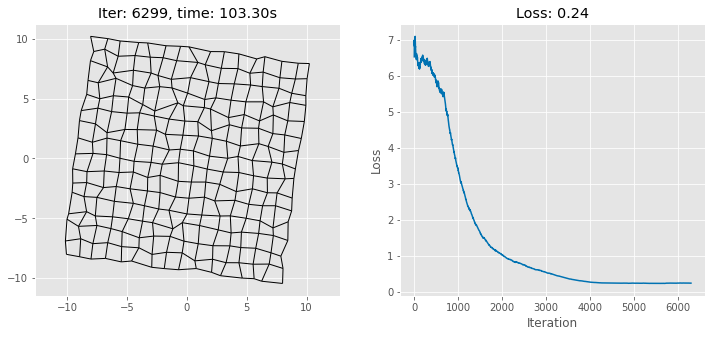

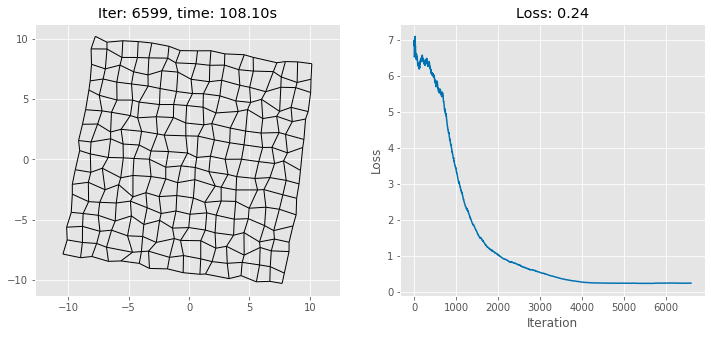

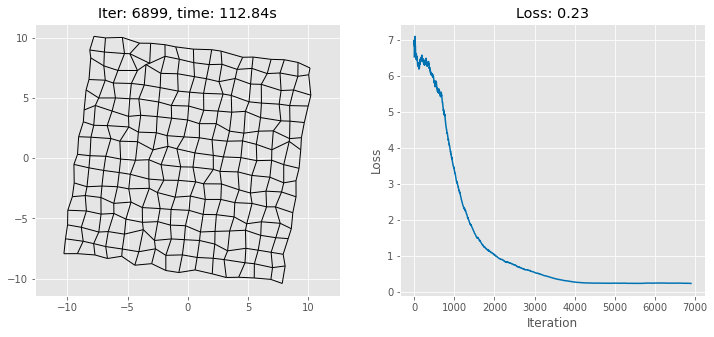

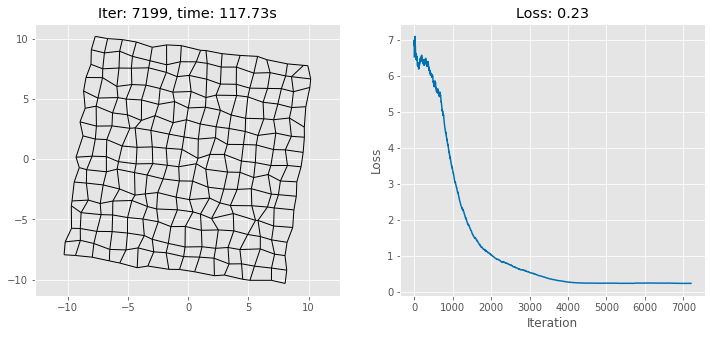

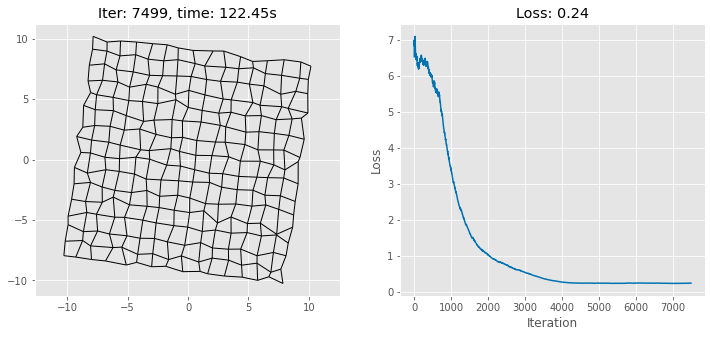

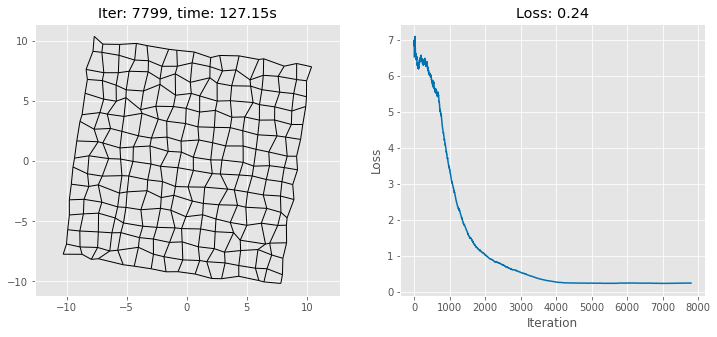

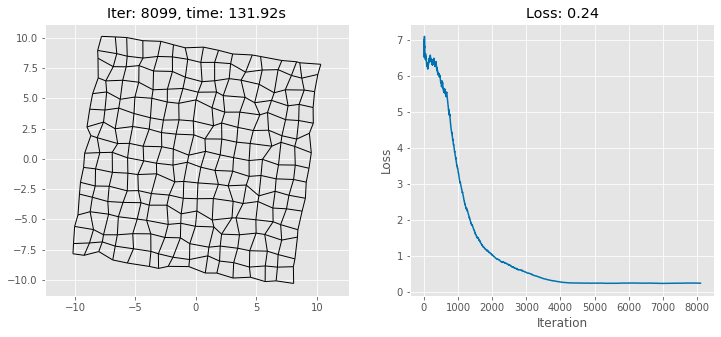

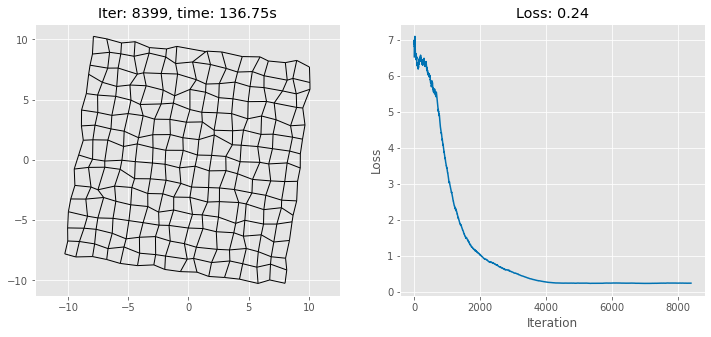

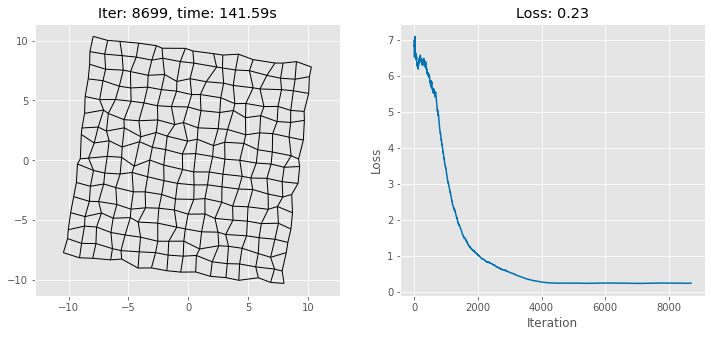

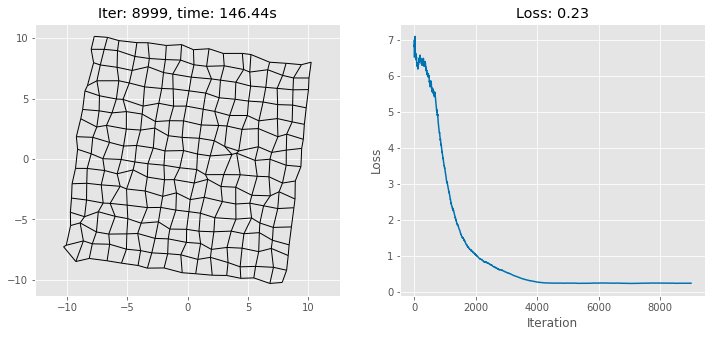

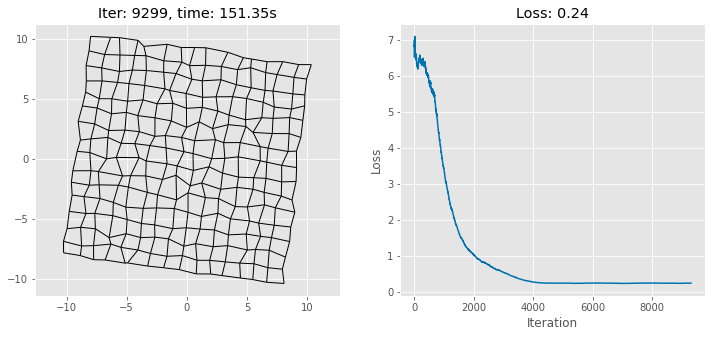

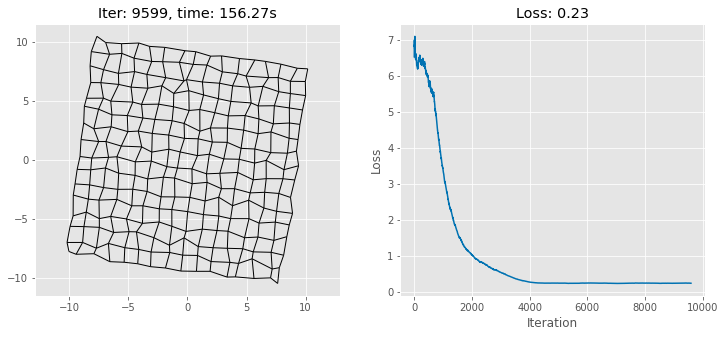

Epoch  9646: reducing learning rate of group 0 to 9.0000e-01.


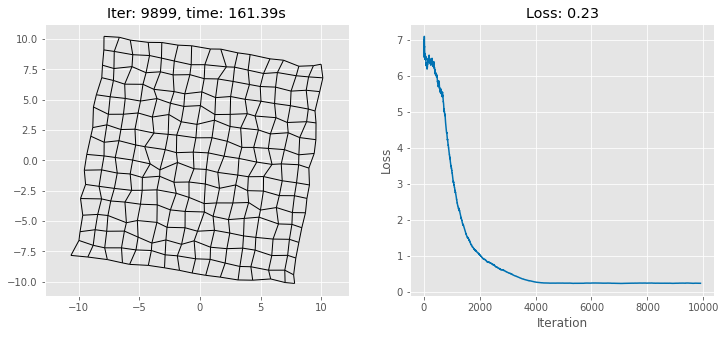

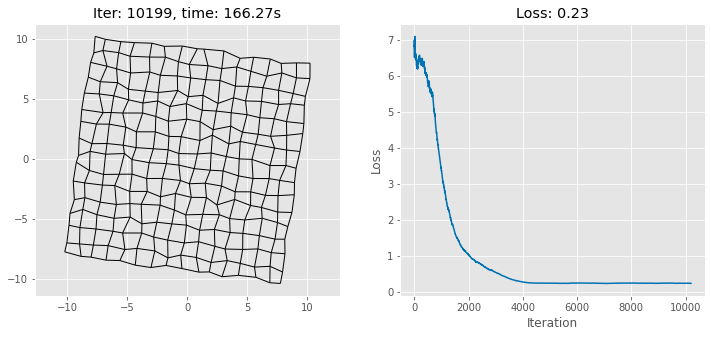

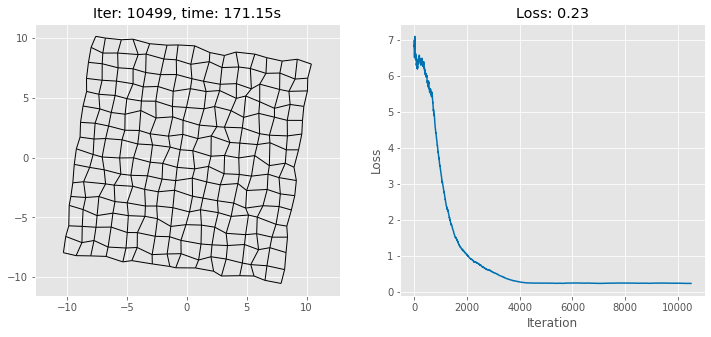

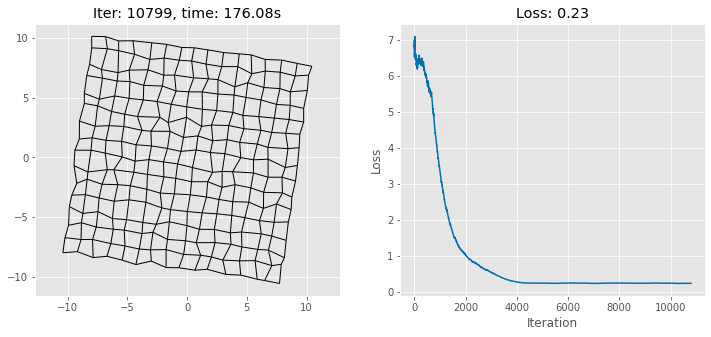

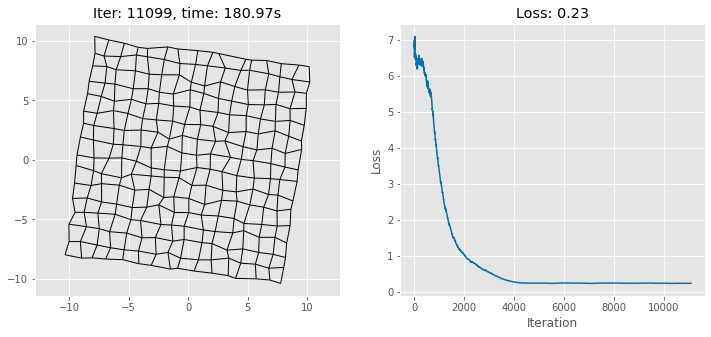

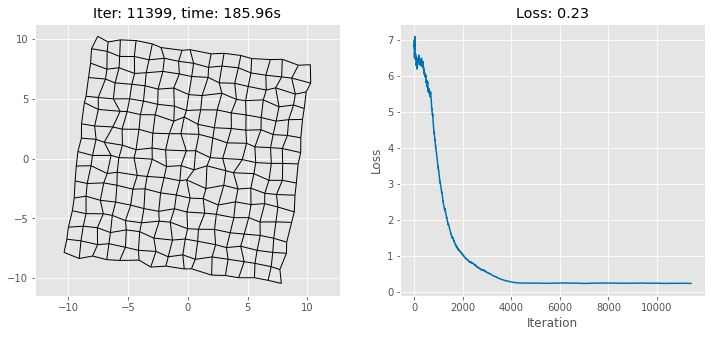

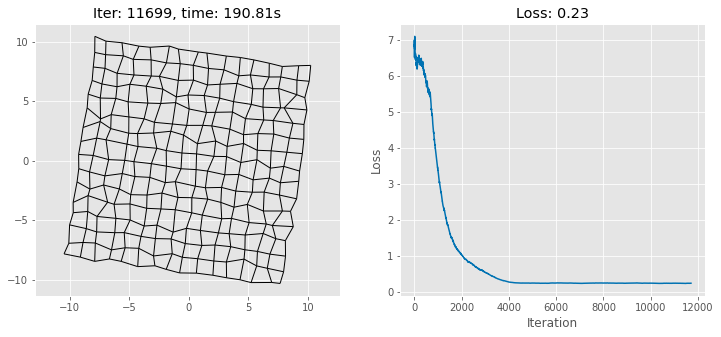

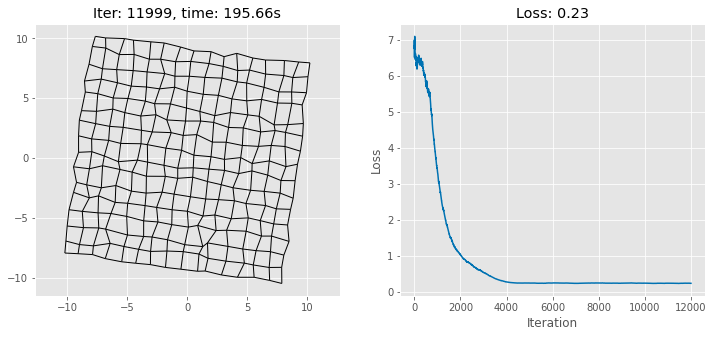

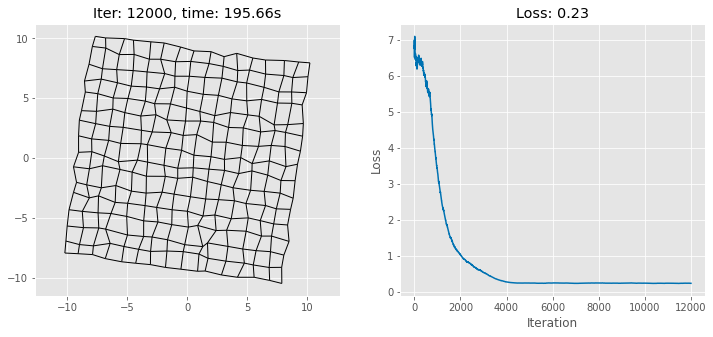

CPU times: user 14min 26s, sys: 4.11 s, total: 14min 30s
Wall time: 3min 24s


In [57]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2


G = nx.grid_2d_graph(16,16)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,5)
# G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])
gd = GD2(G)
qx, qy = 'neighborhood_preservation', 'stress'

result = gd.optimize(
    criteria_weights={
        'stress': 10,
#         'edge_uniformity':1,
        'neighborhood_preservation':0.1,
#         'crossings':1,
#         'crossing_angle_maximization':0.1,
#         'aspect_ratio':10,
#         'angular_resolution':0.1,
#         'vertex_resolution':1,
#         'gabriel':0.01,
    }, 
    sample_sizes={
        'stress': 64,
        'edge_uniformity':1,
        'neighborhood_preservation':16,
        'crossings':1,
        'crossing_angle_maximization':10,
        'aspect_ratio': 'full',
        'angular_resolution':'full',
        'vertex_resolution':int(len(G)**0.5),
        'gabriel':10,
    },
    
#     evaluate='all',
#     evaluate={'stress'},    
#     evaluate={'angular_resolution'},
#     evaluate={'neighborhood_preservation'},
#     evaluate={'crossing_angle_maximization'},
    evaluate={qx, qy},
    
    max_iter=12000, 
    evaluate_interval=120,
    vis_interval=300,
    
    optimizer_kwargs = dict(lr=1),
    scheduler_kwargs = dict(),
)

pos = gd.pos.detach().numpy()
pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
vis.plot(
    gd.G, pos_G,
    gd.loss_curve, 
    result['iter'], result['runtime'],
    edge=True, show=True, save=False
)



Text(0, 0.5, 'stress')

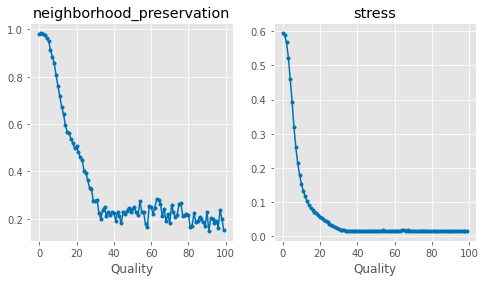

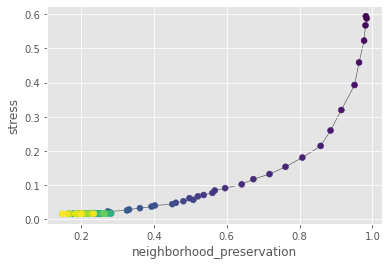

In [61]:
quality_curve_x = [r['qualities'][qx] for r in result['qualities_by_time']]
quality_curve_y = [r['qualities'][qy] for r in result['qualities_by_time']]


plt.figure(figsize=[8,4])
plt.subplot(121)
plt.plot(quality_curve_x, '.-')
plt.title(qx)
plt.xlabel('Iteration')
plt.xlabel('Quality')

plt.subplot(122)
plt.plot(quality_curve_y, '.-')
plt.title(qy)
plt.xlabel('Iteration')
plt.xlabel('Quality')

plt.figure()
plt.plot(quality_curve_x, quality_curve_y, lw=0.5, c='#333333', zorder=-1)
plt.scatter(quality_curve_x, quality_curve_y, c=np.arange(len(quality_curve_x)))
plt.xlabel(qx)
plt.ylabel(qy)

In [ ]:
# from utils import lovasz_losses as L
# a = torch.eye(5)
# pred = torch.randn(5,5)
# L.lovasz_softmax(pred, a)

## Analysis of sample size

In [ ]:
# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# importlib.reload(gd2)

In [ ]:
import pandas as pd
import itertools

In [ ]:
df

In [ ]:
# cm = plt.cm.viridis()

# for result in results:
    
#     sample_size = result['sample_sizes']['stress']
    
#     t = [x['time'] for x in result['qualities_by_time']]
#     stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
#     plt.plot(t, stress, '.-', label=f'sample_size = {sample_size}', color=cm(np.log2(sample_size)/np.log2(512)))
    
# plt.xlabel('Total Time (sec)')
# plt.ylabel('Stress')
# plt.yscale('log')

# plt.xlim([-10,100])
# plt.legend()
# plt.savefig('time-vs-stress-curve-by-sample-size-100sec.png')
# plt.show()

In [ ]:
# df.to_csv('./analysis/balanced-tree-2-8.csv')

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

## Dev

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e6)

shouldVis = True
visIter = 5000

shouldSnap = True
snapIter = 5

gClamp = 4
minLR = 1e-5
maxSampleSize = 64


totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(18,36)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
D, adj_sparse, k2i = utils.shortest_path(G)
adj = torch.from_numpy(adj_sparse.toarray())
D = torch.from_numpy(D)

i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+1e-6)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


optimizer = optim.SGD([pos], lr=0.1, momentum=0.7, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.01)
# optimizer = optim.Adam([pos], lr=0.001)


# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=np.ceil(np.log2(len(G)+1))*100, 
    min_lr=minLR, verbose=True
)
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     lr_lambda=lambda e:1*(1-e/niter)
# )


iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'edge_uniformity',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    
    ## optimization
    optimizer.zero_grad()

    if node_index_pairs_start >= len(node_index_pairs):
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    stress_samples = node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize]
    
    loss = (
        +C.stress(pos, D, W, samples=stress_samples)
#         +0.5*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    totalTime += time.time() - t0
    if loss.isnan():
        raise Exception('loss is nan')
    if pos.isnan().any():
        raise Exception('pos is nan')
    
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'edge_uniformity' in activeQualityMeasures:
            qualityMeasureCurves['edge_uniformity'].append(
                Q.edge_uniformity(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    
    if scheduler is not None:
#         scheduler.step(i)
        scheduler.step(lossCurve[-1])
    

    if optimizer.param_groups[0]['lr'] <= minLR:
#     or pos.grad.max() < 1e-3*(pos.max()-pos.min()):
        print('Done')
        break

In [ ]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

In [ ]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [ ]:
1/len(G)**0.5

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)